In [1]:
from itertools import chain
from collections import OrderedDict

from adult import AdultRaw, Adult
import dill
from sklearn.linear_model import Ridge, LogisticRegression
from sklearn.mixture import GaussianMixture
from scipy.stats import norm, truncnorm, multinomial
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import pandas as pd
import torch
from torch import nn
from tqdm import tqdm

from probspecs import (
    MultidimensionalIndependent,
    ContinuousDistribution1d,
    DiscreteDistribution1d,
    TensorInputSpace,
    TabularInputSpace,
)
from probspecs.population_models import (
    FactorAnalysisModel,
    EncodeOneHot,
    Normalize,
    Denormalize,
    Identity,
)

from input_spaces import adult_input_space

torch.manual_seed(353710130163567)
np.random.seed(2548400)

/home/david/.miniconda3/envs/prob-specs/lib/python3.10/site-packages/torch/utils/cpp_extension.py:25: DeprecationWarning: pkg_resources is deprecated as an API. See https://setuptools.pypa.io/en/latest/pkg_resources.html
  from pkg_resources import packaging  # type: ignore[attr-defined]


# Dataset Overview

<Axes: >

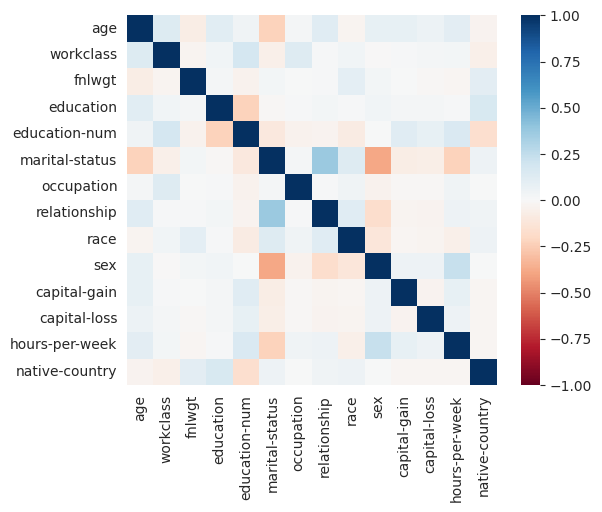

In [2]:
# dataset is with one-hot encodings and normalisation,
# dataset_raw is without.
dataset = Adult(root="../../.datasets", download=True)
test_set = Adult(root="../../.datasets", train=False, download=True)
dataset_raw = AdultRaw(root="../../.datasets", download=True)
test_data_raw = AdultRaw(root="../../.datasets", train=False, download=True)

sns.heatmap(
    torch.corrcoef(dataset_raw.data.T),
    vmin=-1.0, 
    vmax=1.0,
    square=True,
    cmap="RdBu",
    xticklabels=dataset_raw.columns,
    yticklabels=dataset_raw.columns
)


# Population Models

## Linear Population Model
For this population model, we order variables in a causal graph
and subsequently learn linear regression models or linear classifiers
to predict the effect variables from the cause variables in the causal graph.
As we can see from the above plot, most of the variables are only weakly
correlated, however.
We fit suitable probability distributions to the residuals (what remains
after subtracting the linear effects of the cause variables) of all 
continuous effect variables to obtain a complete population model.
For categorical effect variables we fit a discrete probability distribution
that has the option to abstain (produce "no class") for the cases where the
linear classifier can predict the correct class from the cause variables.

Our causal graph is as follows:
- sex and native-country are the root cause variables.
  We assume that sex and native-country are independent, which may make
  intuitive sense, in reality, they may not be independent, for example,
  due to gender imbalances among the people immigrating to the US.
  Since this appears to be irrelevant in the data, we choose not to model
  potential causations between sex and native-country.
- race is determined by native-country (and other unobserved effects). 
- age is determined by sex, race, and native-country (+ unobserved effects).
- education is determined by sex, race, age, and native-country 
  (+ unobserved effects, omitted in the following)
- education-num is determined by education, sex, race, age, and native-country
- All remaining variables are determined by the above variables.
  Some of these variables, such as occupation and relationship might have (circular)
  interactions, that we choose not to model.
- Among all these variables, we only treat capital-gain and capital-loss
  specially. These are completely determined (no unobserved effects) by an
  auxiliary variable capital-change (having unobserved effects).
  capital-gain is simply capital-chance if capital-change is positive and 0.0
  otherwise. 
  Similarly, capital-loss is capital-change if capital-change is negative and
  0.0 otherwise.


In [3]:
causal_graph = OrderedDict([
    ("sex", []),
    ("native-country", []),
    ("race", ["native-country"]),
    ("age", ["sex", "race", "native-country"]),
    ("education", ["sex", "race", "native-country", "age"]),
    ("education-num", ["sex", "race", "native-country", "age", "education"]),
    ("workclass", ["sex", "race", "native-country", "age", "education", "education-num"]),
    ("fnlwgt", ["sex", "race", "native-country", "age", "education", "education-num"]),
    ("marital-status", ["sex", "race", "native-country", "age", "education", "education-num"]),
    ("occupation", ["sex", "race", "native-country", "age", "education", "education-num"]),
    ("relationship", ["sex", "race", "native-country", "age", "education", "education-num"]),
    ("hours-per-week", ["sex", "race", "native-country", "age", "education", "education-num"]),
    ("capital-change", ["sex", "race", "native-country", "age", "education", "education-num"]),
])
col_idx = {
    var: [
        i 
        for i, col in enumerate(dataset.columns) 
        if col == var or col.startswith(f"{var}=")
    ]
    for var in adult_input_space.attribute_names
}
col_raw_id = {  # for accessing non-one-hot-encoded categorical variables
    var: dataset_raw.columns.index(var)
    for var in adult_input_space.attribute_names
}
col_idx["capital-change"] = [-1]

capital_chance = dataset.data[:, col_idx["capital-gain"]] - dataset.data[:, col_idx["capital-loss"]]
data = torch.hstack([dataset.data, capital_chance])
test_capital_chance = test_set.data[:, col_idx["capital-gain"]] - test_set.data[:, col_idx["capital-loss"]]
test_data = torch.hstack([test_set.data, test_capital_chance])


### Build the linear models

In [4]:
def fit_continuous(effect_var, cause_vars):
    cause_idx = list(chain(*[col_idx[var] for var in cause_vars]))
    inputs = data[:, cause_idx]
    target = data[:, col_idx[effect_var]]
    regressor = Ridge()
    regressor.fit(inputs, target)

    train_score = regressor.score(inputs, target)
    inputs = test_data[:, cause_idx]
    target = test_data[:, col_idx[effect_var]]
    test_score = regressor.score(inputs, target)
    print()
    print(f"{effect_var} <- {cause_vars}")
    print(f"R-Squared (Train): {train_score:.4f}")
    print(f"R-Squared (Test):  {test_score:.4f}")
    
    return regressor

def fit_categorical(effect_var, cause_vars):
    cause_idx = list(chain(*[col_idx[var] for var in cause_vars]))
    inputs = data[:, cause_idx]
    target = dataset_raw.data[:, col_raw_id[effect_var]]
    classifier = LogisticRegression(
        class_weight="balanced", multi_class="multinomial", max_iter=600,
    )
    classifier.fit(inputs, target)

    train_score = classifier.score(inputs, target)
    inputs = test_data[:, cause_idx]
    target = test_data_raw.data[:, col_raw_id[effect_var]]
    test_score = classifier.score(inputs, target)
    print()
    print(f"{effect_var} <- {cause_vars}")
    print(f"Accuracy (Train): {train_score:.4f}")
    print(f"Accuracy (Test):  {test_score:.4f}")
    
    return classifier

predictors = {}
for var, causes in causal_graph.items():
    if len(causes) > 0:
        if len(col_idx[var]) == 1:
            predictors[var] = fit_continuous(var, causes)
        else:
            predictors[var] = fit_categorical(var, causes)



race <- ['native-country']
Accuracy (Train): 0.0514
Accuracy (Test):  0.0485

age <- ['sex', 'race', 'native-country']
R-Squared (Train): 0.0162
R-Squared (Test):  0.0114

education <- ['sex', 'race', 'native-country', 'age']
Accuracy (Train): 0.0571
Accuracy (Test):  0.0568

education-num <- ['sex', 'race', 'native-country', 'age', 'education']
R-Squared (Train): 1.0000
R-Squared (Test):  1.0000

workclass <- ['sex', 'race', 'native-country', 'age', 'education', 'education-num']
Accuracy (Train): 0.2579
Accuracy (Test):  0.2509

fnlwgt <- ['sex', 'race', 'native-country', 'age', 'education', 'education-num']
R-Squared (Train): 0.0544
R-Squared (Test):  0.0492

marital-status <- ['sex', 'race', 'native-country', 'age', 'education', 'education-num']
Accuracy (Train): 0.4855
Accuracy (Test):  0.4854

occupation <- ['sex', 'race', 'native-country', 'age', 'education', 'education-num']
Accuracy (Train): 0.2012
Accuracy (Test):  0.1929

relationship <- ['sex', 'race', 'native-country', 'ag

### Fit probability distributions to residuals
For continuous variables, we fit normal distributions to the residuals.
For categorical variables, we fit multinoulli (multi-class Bernoulli) distributions.


In [12]:
def distribution_continuous(residuals_, var):
    mean_ = residuals_.mean().item()
    std_ = residuals_.std().item()
    var_i = adult_input_space.attribute_names.index(var)
    # TODO: not the same space + a, b should be in multiples of std-devs
    min_, max_ = adult_input_space.attribute_bounds(var_i)
    print(var, var_i, min_, max_, mean_, std_)
    return truncnorm(
        a=min_, b=max_, loc=mean_, scale=std_
    )

def distribution_gaussian_mixture(residuals_, n_components):
    mixture_model = GaussianMixture(
        n_components, covariance_type="spherical", n_init=5,
    )
    mixture_model.fit(residuals_)
    return mixture_model

def distribution_categorical(residuals_, is_root_cause=False):
    class_frequencies = residuals_.mean(dim=0).tolist()
    abstain_frequency = 1.0 - sum(class_frequencies)
    if not is_root_cause:
        class_frequencies += [abstain_frequency]
    return multinomial(n=1, p=class_frequencies)

distributions = {}
for var, causes in causal_graph.items():
    residuals = data[:, col_idx[var]]
    if len(causes) > 0:
        cause_values = data[:, list(chain(*[col_idx[var] for var in causes]))]
        if len(col_idx[var]) == 1:  # continuous
            predictions = predictors[var].predict(cause_values)
            residuals = residuals - predictions
        else:  # categorical
            predictions = predictors[var].predict_proba(cause_values)
            predictions = torch.as_tensor(predictions)
            max_probabilities = torch.amax(predictions, dim=1)
            predictions_one_hot = predictions == max_probabilities.unsqueeze(-1)
            # keep original class if predictor errs, otherwise set residual
            # for a sample to all zero
            residuals = torch.clip(residuals - predictions_one_hot.float(), min=0.0)
    if var == "capital-change":
        distributions[var] = distribution_gaussian_mixture(residuals, n_components=5)
    elif len(col_idx[var]) == 1:
        distributions[var] = distribution_continuous(residuals, var)
    else:
        distributions[var] = distribution_categorical(
            residuals, is_root_cause=len(causes) == 0
        )


age 0 17.0 90.0 -4.428818855609669e-17 0.9918632992982972
education-num 4 1.0 16.0 2.2618926086869528e-17 0.003310987153782459
fnlwgt 2 10000.0 1500000.0 -1.5783556559885522e-17 0.9724436263866125
hours-per-week 12 1.0 99.0 -1.790373579927313e-17 0.9509464861492113


### Compare the data distribution with the distribution of the population model


In [6]:
n = 10000
generated = {}
for var, causes in tqdm(causal_graph.items()):
    if len(col_idx[var]) == 1:
        if len(causes) == 0:
            var_data = torch.as_tensor(distributions[var].rvs(n))
        else:
            cause_values = torch.hstack([generated[cause] for cause in causes])
            predicted = predictors[var].predict(cause_values)
            predicted = torch.as_tensor(predicted)
            if isinstance(distributions[var], GaussianMixture):
                gmm = distributions[var]
                select_normal = multinomial.rvs(n=1, p=gmm.weights_, size=n)
                select_normal = torch.as_tensor(select_normal)
                normally_distributed = torch.hstack([
                    torch.as_tensor(norm.rvs(
                        loc=mean_,
                        scale=var_,
                        size=(n, 1),
                    ))
                    for mean_, var_ in zip(gmm.means_, gmm.covariances_)
                ])
                residual = torch.masked_select(normally_distributed, select_normal.bool())
                residual = residual.reshape(n, 1)
            else:
                residual = distributions[var].rvs((n, 1))
                residual = torch.as_tensor(residual)
            var_data = predicted + residual
    else:
        residual = distributions[var].rvs(n)
        residual = torch.as_tensor(residual)
        if len(causes) == 0:
            var_data = residual
        else:
            residual = residual[:, :-1]  # drop abstain column
            cause_values = torch.hstack([generated[cause] for cause in causes])
            predicted = predictors[var].predict_proba(cause_values)
            predicted = torch.as_tensor(predicted)
            var_data = predicted + residual
        max_values = torch.amax(var_data, dim=1)
        var_data = (var_data == max_values.unsqueeze(-1)).float()
    generated[var] = var_data
    
# compute capital gain and capital loss
capital_gain = torch.clip(generated["capital-change"], min=0)
capital_loss = -torch.clip(generated["capital-change"], max=0)
generated["capital-gain"] = capital_gain
generated["capital-loss"] = capital_loss


100%|██████████| 13/13 [00:00<00:00, 113.83it/s]


In [7]:
generated_raw = {}

# for reversing normalization
means = torch.mean(dataset_raw.data, dim=0)
stds = torch.std(dataset_raw.data, dim=0)
for i, var in enumerate(adult_input_space.attribute_names):
    if len(col_idx[var]) == 1:
        generated_raw[var] = stds[i] * generated[var].squeeze() + means[i]
    else:
        # convert all one-hot encodings to value indices
        var_one_hot = generated[var]
        var_values = torch.argmax(var_one_hot, dim=1)
        generated_raw[var] = var_values

generated_df = pd.DataFrame(generated_raw)
data_df = pd.DataFrame(dataset_raw.data, columns=dataset_raw.columns)
# test_data_df = pd.DataFrame(test_data_raw.data, columns=test_data_raw.columns)

generated_df["dataset"] = "generated"
data_df["dataset"] = "train"
# test_data_df["dataset"] = "test"
df = pd.concat([generated_df, data_df])


#### Plot Marginal Distributions

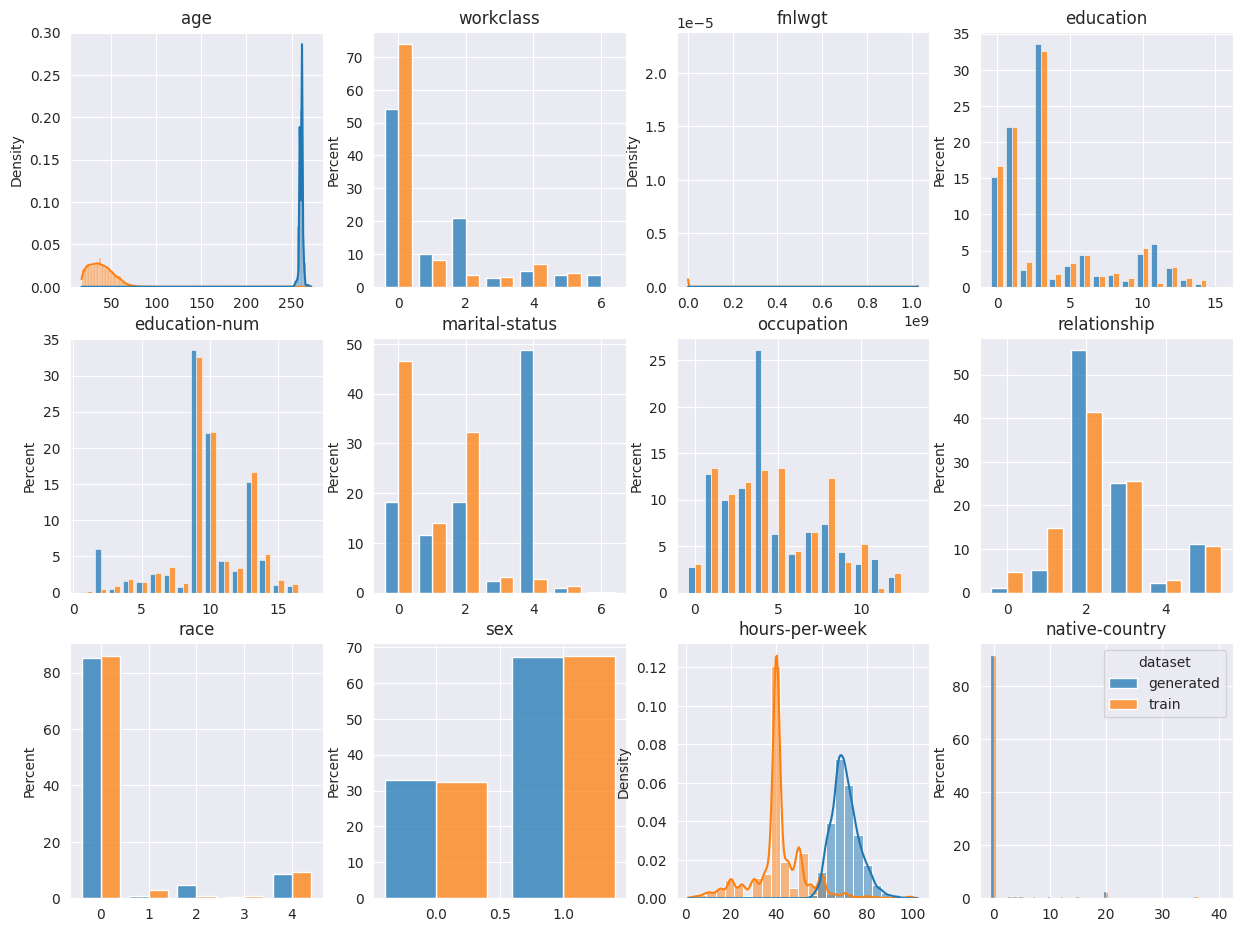

In [8]:
%%capture --no-stdout --no-display
fig, axes = plt.subplots(3, 4, figsize=(15, 11.25))
axes = axes.flatten()
vars = [var for var in adult_input_space.attribute_names if not var.startswith("capital")]
for var, ax in zip(vars, axes):
    ax.set_title(var)
    if len(col_idx[var]) > 1 or var == "education-num":
        kwargs = {}
        kwargs["legend"] = var == "native-country"
        g = sns.histplot(
            df,
            x=var,
            hue="dataset",
            discrete=True,
            shrink=.8,
            multiple="dodge",
            stat="percent",
            common_norm=False,
            ax=ax,
            **kwargs,
        )
    else:
        kwargs = {}
        if var == "hours-per-week":
            kwargs["bins"] = 25
        g = sns.histplot(
            df,
            x=var,
            hue="dataset",
            legend=False,
            stat="density",
            common_norm=False,
            kde=True,
            ax=ax,
            **kwargs,
        )
    g.set(xlabel=None)


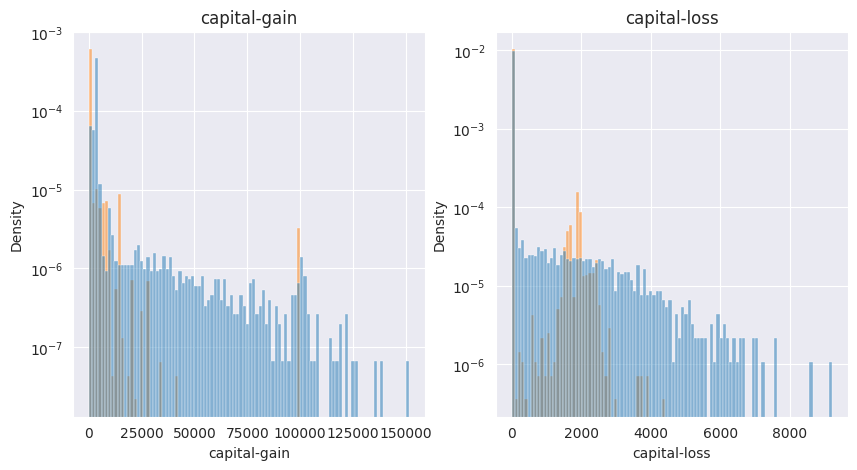

In [11]:
%%capture --no-stdout --no-display
fig, axes = plt.subplots(1, 2, figsize=(10, 5))

for var, ax in zip(("capital-gain", "capital-loss"), axes):
    ax.set_title(var)
    sns.histplot(
        df,
        x=var,
        hue="dataset",
        legend=False,
        stat="density",
        common_norm=False,
        log_scale=(False, True),
        bins=100,
        ax=ax,
    )


#### Plot Correlation Matrix


<Axes: title={'center': 'Training Data'}>

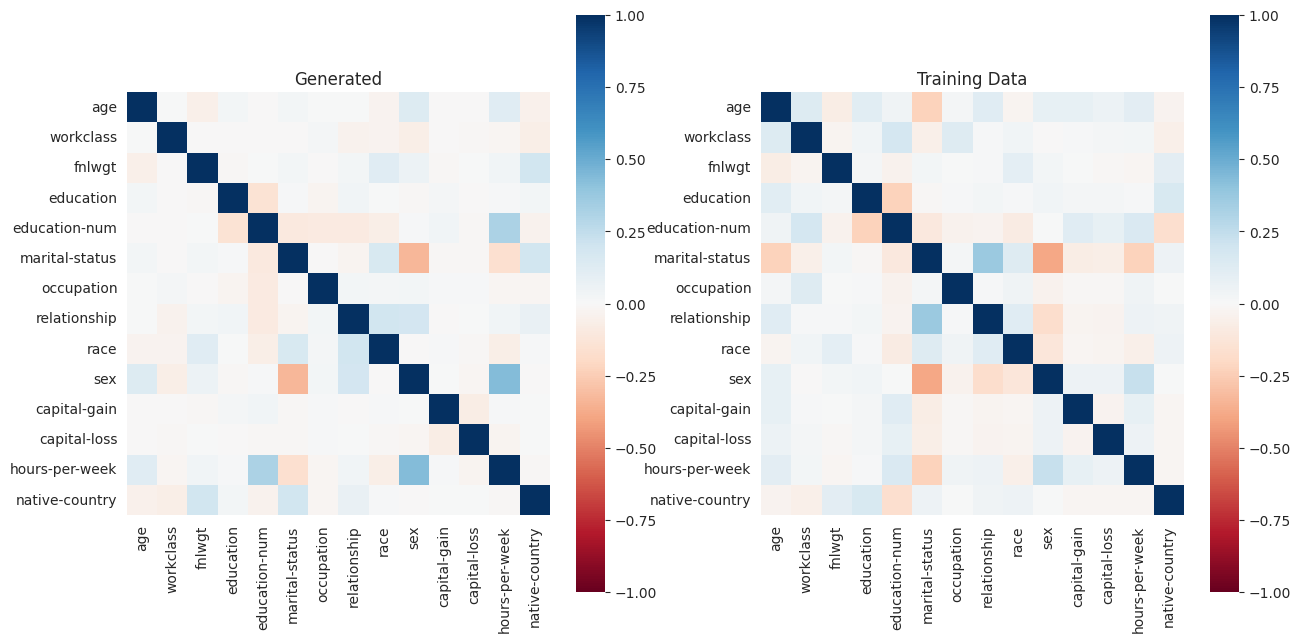

In [107]:
fig, axes = plt.subplots(1, 2, figsize=(15, 7.5))

axes[0].set_title("Generated")
generated_df_ = generated_df.drop("dataset", axis=1)
sns.heatmap(
    np.corrcoef(generated_df_.to_numpy().T),
    vmin=-1.0,
    vmax=1.0,
    square=True,
    cmap="RdBu",
    xticklabels=dataset_raw.columns,
    yticklabels=dataset_raw.columns,
    ax=axes[0]
)
axes[1].set_title("Training Data")
sns.heatmap(
    torch.corrcoef(dataset_raw.data.T),
    vmin=-1.0,
    vmax=1.0,
    square=True,
    cmap="RdBu",
    xticklabels=dataset_raw.columns,
    yticklabels=dataset_raw.columns,
    ax=axes[1]
)


# Build Population Models

## Factor Analysis Population Model
Based on Factor Analysis: The factors are uncorrelated jointly normally distributed with mean zero, zero covariance and variance 1.
Similarly, the noise terms are jointly normally distributed with zero mean, zero covariance and certain fixed variances.
Since the factors and noise terms are jointly normally distributed and uncorrelated, they are independent.

In [30]:
W = factor_analysis.components_
W

array([[ 1.02867721e-01,  8.69680330e-04,  2.73864986e-02,
         2.69643349e-02, -2.13385937e-02,  3.85837451e-01,
         6.97177226e-03,  8.83516946e-01,  1.23301774e-01,
        -1.52737119e-01, -2.17263527e-02, -3.13971361e-02,
         9.37048993e-02,  5.45118337e-02],
       [-2.89949332e-02, -1.93292579e-01,  5.98555147e-02,
         2.75786920e-01, -8.64823625e-01,  8.40328354e-02,
         3.37845475e-02,  1.46828806e-02,  8.14180769e-02,
         1.90155564e-02, -1.30033548e-01, -8.15993817e-02,
        -1.59073577e-01,  2.02141940e-01],
       [-6.89355093e-01, -2.12369966e-01,  1.11336470e-01,
        -1.65872802e-01, -2.36479921e-02,  2.84199762e-01,
        -6.82551225e-02, -5.94147081e-02,  1.72563527e-02,
        -3.61439145e-02, -8.69175347e-02, -7.14529026e-02,
        -6.87600254e-02,  4.70975732e-02],
       [-1.24460790e-01,  4.20120440e-02, -2.54056033e-02,
        -4.06002030e-02, -3.23795206e-02,  5.33865202e-01,
         5.40021515e-02,  7.88610154e-02,  1.

In [31]:
eps_var = factor_analysis.noise_variance_
np.atleast_2d(eps_var)

array([[0.49777753, 0.91574525, 0.98259261, 0.89401638, 0.25003991,
        0.478232  , 0.99120523, 0.20956063, 0.95441242, 0.62442246,
        0.96874377, 0.9826305 , 0.78506219, 0.95376573]])

In [32]:
# Truncate normal distributions after four standard deviations.
# Covers >0.9999 of the probability mass of a regular normal distribution.
ran = 4.0
factor_distributions = [
    ContinuousDistribution1d(truncnorm(a=-ran, b=ran, loc=0.0, scale=1.0))
    for _ in range(W.shape[0])
]
noise_std = np.sqrt(eps_var)
noise_distributions = [
    ContinuousDistribution1d(truncnorm(a=-ran * std, b=ran * std, loc=0.0, scale=std))
    for std in noise_std
]
factor_analysis_distribution = MultidimensionalIndependent(
    *(factor_distributions + noise_distributions),
    input_shape=(W.shape[0] + eps_var.shape[0],)
)

factor_analysis_input_space = TensorInputSpace(
    lbs=torch.tensor([-ran] * W.shape[0] + (-ran * noise_std).tolist()),
    ubs=torch.tensor([ran] * W.shape[0] + (ran * noise_std).tolist()),
)

# pick 0.0 means for categorical/one-hot encoded attributes
continuous_mean = torch.tensor(
    [
        mean[i] if isinstance(values, int) else 0.0
        for i, values in enumerate(adult_input_space.encoding_layout.values())
        for _ in ((None,) if isinstance(values, int) else values)
    ]
)
continuous_std = torch.tensor(
    [
        std[i] if isinstance(values, int) else 1.0
        for i, values in enumerate(adult_input_space.encoding_layout.values())
        for _ in ((None,) if isinstance(values, int) else values)
    ]
)

from_factors_and_noise = FactorAnalysisModel(factor_loadings=torch.as_tensor(W).T)
mean_, std_ = torch.atleast_2d(mean, std)
denormalize = Denormalize(mean_, std_)
encode_one_hot = EncodeOneHot(
    [
        None if isinstance(values, int) else len(values)
        for values in adult_input_space.encoding_layout.values()
    ]
)
continuous_mean, continuous_std = torch.atleast_2d(continuous_mean, continuous_std)
normalize = Normalize(continuous_mean, continuous_std)
factor_analysis_population_model = nn.Sequential(
    from_factors_and_noise,
    denormalize,
    encode_one_hot,
    normalize,
    Identity(105),  # provide explicit shape information for auto_LiRPA
)

Investigate some empirical properties of the factor analysis population model

In [33]:
n = len(dataset)

factors = torch.randn((n, W.shape[0]))
noise = torch.randn((n, eps_var.shape[0])) * noise_std
x = torch.hstack([factors, noise]).float()
z = factor_analysis_population_model(x)
z_denorm = z * continuous_std + continuous_mean

print("Attribute                  | Population Model | Data")
print("------------------------------------------------------")
frac_female_pop_model = z[:, adult_input_space.encoding_layout["sex"]["Female"]].mean()
frac_male_pop_model = z[:, adult_input_space.encoding_layout["sex"]["Male"]].mean()
sex_data = dataset.data[:, list(adult_input_space.encoding_layout).index("sex")]
frac_female_data = (sex_data == 0.0).float().mean()
frac_male_data = (sex_data == 1.0).float().mean()
print("Sex                        |                  |")
print(
    f"Female                     | {frac_female_pop_model:5.4f}           | {frac_female_data:.4f}"
)
print(
    f"Male                       | {frac_male_pop_model:5.4f}           | {frac_male_data:.4f}"
)
print("Race                       |                  |")
race_data = dataset.data[:, list(adult_input_space.encoding_layout).index("race")]
for i, edu_val in enumerate(
    adult_input_space.attribute_values(adult_input_space.attribute_names.index("race"))
):
    frac_pop_model = z[:, adult_input_space.encoding_layout["race"][edu_val]].mean()
    frac_data = (race_data == i).float().mean()
    print(f"{edu_val:26} | {frac_pop_model:5.4f}           | {frac_data:5.4f}")
print("Age                        |                  |")
age_data = dataset.data[:, list(adult_input_space.encoding_layout).index("age")]
for threshold in range(0, 110, 20):
    frac_pop_model = (
        (z_denorm[:, adult_input_space.encoding_layout["age"]] <= threshold)
        .float()
        .mean()
    )
    frac_data = (age_data <= threshold).float().mean()
    print(
        f"age <= {threshold:3}                 | {frac_pop_model:5.4f}           | {frac_data:5.4f}"
    )
# education
print("Education                  |                  |")
edu_data = dataset.data[:, list(adult_input_space.encoding_layout).index("education")]
for i, edu_val in enumerate(
    adult_input_space.attribute_values(
        adult_input_space.attribute_names.index("education")
    )
):
    frac_pop_model = z[
        :, adult_input_space.encoding_layout["education"][edu_val]
    ].mean()
    frac_data = (edu_data == i).float().mean()
    print(f"{edu_val:26} | {frac_pop_model:5.4f}           | {frac_data:5.4f}")

Attribute                  | Population Model | Data
------------------------------------------------------
Sex                        |                  |
Female                     | 0.3552           | 0.3243
Male                       | 0.6448           | 0.6757
Race                       |                  |
White                      | 0.5228           | 0.8598
Asian-Pac-Islander         | 0.2915           | 0.0297
Amer-Indian-Eskimo         | 0.1422           | 0.0095
Other                      | 0.0377           | 0.0077
Black                      | 0.0058           | 0.0934
Age                        |                  |
age <=   0                 | 0.0015           | 0.0000
age <=  20                 | 0.0799           | 0.0662
age <=  40                 | 0.5473           | 0.5888
age <=  60                 | 0.9507           | 0.9401
age <=  80                 | 0.9990           | 0.9975
age <= 100                 | 1.0000           | 1.0000
Education                  |     

## Independent Variables Population Model
Assume that continuous variables are normally distributed
while categorical variables are multinomially distributed.


In [ ]:
# We truncate normal distributions after four standard deviations as 
# for the factor analysis population model
ran = 4.0

def get_continuous(i):
    mean_ = mean[i]
    std_ = std[i]
    return ContinuousDistribution1d(truncnorm(a=-ran*std, b=ran*std, loc=mean_, scale=std_))

def get_categorical(i, num_values):
    values = dataset.data[:, i]  # not normalised
    frequencies = [(values == k).float().mean() for k in range(num_values)]
    return DiscreteDistribution1d(multinomial(n=1, p=np.array(frequencies)))

distributions = []
for i, attr_type in enumerate(adult_input_space.attribute_types):
    match attr_type:
        case TabularInputSpace.AttributeType.CONTINUOUS:
            distr = get_continuous(i)
        case TabularInputSpace.AttributeType.ORDINAL:
            # only fnlwgt is ordinal, which starts from 0
            distr = get_categorical(i, adult_input_space.attribute_bounds(i)[1] + 1)
        case TabularInputSpace.AttributeType.CATEGORICAL:
            distr = get_categorical(i, len(adult_input_space.attribute_values(i)))
        case _:
            raise NotImplementedError()
    distributions.append(distr)
independent_distribution = MultidimensionalIndependent(*distributions, input_shape=(len(distributions),))


## Save the population models

In [12]:
with open("../../resources/adult/factor_analysis_distribution.dill", "wb") as file:
    dill.dump(factor_analysis_distribution, file)
with open("../../resources/adult/factor_analysis_input_space.dill", "wb") as file:
    dill.dump(factor_analysis_input_space, file)
torch.save(
    factor_analysis_population_model,
    "../../resources/adult/factor_analysis_population_model.pyt",
)